# Rozpoznawanie odręcznych rysunków

Korzystając z Google Quick Draw dataset (https://github.com/googlecreativelab/quickdraw-dataset)  
The dataset contains around 50 million drawings of 345 classes.

<img src = 'quickdraw.png' ?>

## Pipeline

We will train the model on GPU for free on Google Colab using Keras then run it on the browser directly using TensorFlow.js(tfjs) .

In [8]:
import os
import glob
import numpy as np
from keras.models import Sequential
from keras.layers import Activation, Flatten, Convolution2D, MaxPooling2D, Dense
import keras
import tensorflow as tf

## Load the Data
Since we have a limited memory we will not train on all the classes. We will only use 100 classes of the dataset. The data for each class is available on Google Cloud as numpy arrays of the shape [N,784] where N is the number of of the images for that particular class. We first download the dataset

In [9]:
# with open('data_c/classes.txt') as f:
#     classes = f.readlines()
# classes = [c.replace('\n', '') for c in classes]
# classes = [c.replace(' ', '_') for c in classes]
# print(classes)



In [10]:
class_names = ['drums', 'spider', 'flowers', 'clock', 'airplane', 'face', 'sun', 'bicycle']

In [11]:
import urllib.request

def download():
    base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
    list = []
    for c in class_names:
        cls_url = c.replace('_', '%20')
        path = base + cls_url + '.npy'
        list.append(path)
        #urllib.request.urlretrieve(path, 'data/'+ c)
    return list

lista = download()

In [12]:
with open('linki.txt', 'w') as f:
    for link in lista:
        f.write('{}\n'.format(link))





In [13]:
# Since our memory is limited we will only load to memory 5000 images per classes.  
# We also reserve 20% of the data unseen for testing

def load_data(root, vfold_ratio = 0.2, max_items_per_class = 10000):
    all_files = glob.glob(os.path.join(root, '*.npy'))
    
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []
    class_index = {}
    
    for file_number, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, : ]
        labels = np.full(data.shape[0], file_number)
        
        x = np.concatenate((x, data), axis = 0)
        y = np.append(y, labels)
        
        class_name, ext = os.path.splitext(os.path.basename(file))
        
        class_names.append(class_name)
        class_index[file_number] = class_name
        
    data = None
    labels = None
    
    #separate into training and testing
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, : ]
    y = y[permutation]
    
    vfold_size = int(x.shape[0]/100*(vfold_ratio * 100))
    
    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]
    
    x_train = x[vfold_size: x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    
    return x_train, y_train, x_test, y_test, class_names, class_index
    


## Preprocess the Data
We preprocess the data to prepare it for training.  
The model will take batches of the shape [N, 28, 28, 1] and outputs probabilities of the shape [N, 100]

In [14]:
x_train, y_train, x_test, y_test, class_names, class_index = load_data('data')

num_classes = len(class_names)
image_size = 28

x_train = 255.0 - x_train
x_test = 255.0 - x_test

x_train /= 255.0
x_test /= 255.0

In [15]:
x_train.shape, y_train.shape

((32000, 784), (32000,))

In [16]:
class_index

{0: 'airplane',
 1: 'bicycle',
 2: 'clock',
 3: 'drums',
 4: 'face',
 5: 'flower',
 6: 'spider',
 7: 'sun'}

bicycle


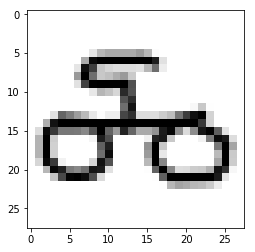

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

obrazek = 562

plt.imshow(x_train[obrazek].reshape(28,28), cmap = 'gray')
print(class_index[y_train[obrazek]])

In [18]:
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')


y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Building the model

We will create a simple CNN. Notice that the simpler the model with lesser number of parameters the better. Indeed, we will run the model after conversion on the browser and we want the model to run fast for prediction. The following model contains 3 conv layers and 2 dense layers.

In [19]:
model = Sequential()

model.add(Convolution2D(16, (3,3), padding='same', activation = 'relu', input_shape = x_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3, 2), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dense(8, activation='softmax'))

In [23]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['top_k_categorical_accuracy'])

In [24]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        3104      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
__________

In [ ]:
model.fit(x=x_train, y=y_train, validation_split=0.1, batch_size=256, epochs=10 )

Train on 28800 samples, validate on 3200 samples
Epoch 1/10
28800/28800 [==============================] - 30s 1ms/step - loss: 0.2856 - top_k_categorical_accuracy: 0.9941 - val_loss: 0.2900 - val_top_k_categorical_accuracy: 0.9928
Epoch 2/10
28800/28800 [==============================] - 30s 1ms/step - loss: 0.2571 - top_k_categorical_accuracy: 0.9950 - val_loss: 0.2768 - val_top_k_categorical_accuracy: 0.9919
Epoch 3/10
28800/28800 [==============================] - 30s 1ms/step - loss: 0.2369 - top_k_categorical_accuracy: 0.9951 - val_loss: 0.2655 - val_top_k_categorical_accuracy: 0.9928
Epoch 4/10
28800/28800 [==============================] - 31s 1ms/step - loss: 0.2187 - top_k_categorical_accuracy: 0.9955 - val_loss: 0.2571 - val_top_k_categorical_accuracy: 0.9922
Epoch 5/10
28800/28800 [==============================] - 36s 1ms/step - loss: 0.2006 - top_k_categorical_accuracy: 0.9959 - val_loss: 0.2419 - val_top_k_categorical_accuracy: 0.9925
Epoch 6/10
28800/28800 [============

In [112]:
score = model.evaluate(x_test, y_test)
print(f'{score[1]:.2f}')

8000/8000 [==============================] - 3s 338us/step
0.90


# Prepare the model for Web Format

In [113]:
model.save('quickdraw.h5')

In [ ]:
!pip install tensorflowjs